# Imports

In [86]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
!pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
# Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd

In [87]:
def download(ticker):
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
    df = yf.download(ticker, 
                period = '60d', # A period of 2 years from today
                prepost = False, # Pre and Post markets included
                threads = True, # Multi-thread processing for faster output.
                interval = '15m')
    return df
df = download("TSLA")

#data cleaning
print(df.describe())
print(df.isna().sum())


[*********************100%***********************]  1 of 1 completed
              Open         High          Low        Close    Adj Close  \
count  1553.000000  1553.000000  1553.000000  1553.000000  1553.000000   
mean    728.283712   731.511048   724.839233   728.194899   728.194899   
std      81.836774    81.437588    82.259482    81.876258    81.876258   
min     546.390015   562.619995   539.489990   546.710022   546.710022   
25%     673.799988   676.489990   670.419983   673.494995   673.494995   
50%     701.945312   704.630005   699.090027   701.869873   701.869873   
75%     799.562927   801.700012   796.349976   799.000000   799.000000   
max     895.599976   900.400024   888.504272   895.619995   895.619995   

             Volume  
count  1.553000e+03  
mean   1.262387e+06  
std    1.040092e+06  
min    0.000000e+00  
25%    6.373750e+05  
50%    9.573760e+05  
75%    1.520248e+06  
max    1.390479e+07  
Open         0
High         0
Low          0
Close        0
Adj Cl

<AxesSubplot:xlabel='Datetime'>

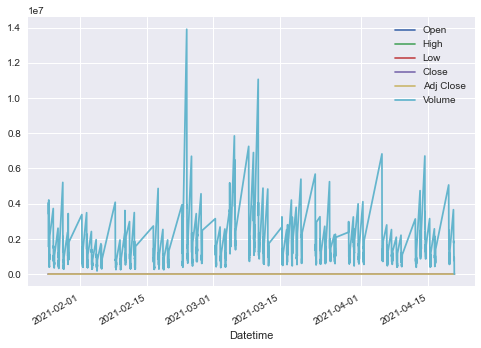

In [88]:
#original Data
df.plot()

In [89]:
def get_indicators(data):
    #calculate all indicators
    open =data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    data['returns']=data['Close'].pct_change()
    data['volatility']=data['returns'].rolling(window=32).std()*(252**0.5)
    data['rsi']=ta.momentum.rsi(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data =data.dropna()
    return data

<AxesSubplot:xlabel='Datetime'>

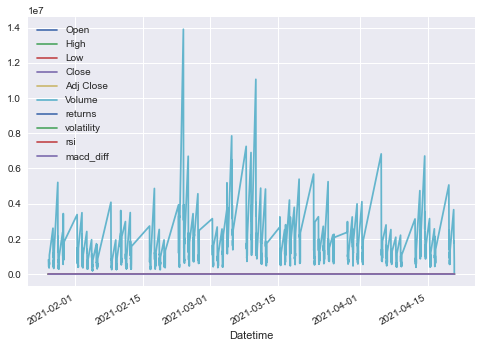

In [90]:
df_indicators.plot()

<AxesSubplot:xlabel='Datetime'>

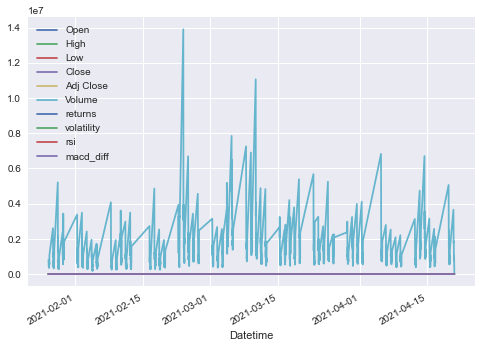

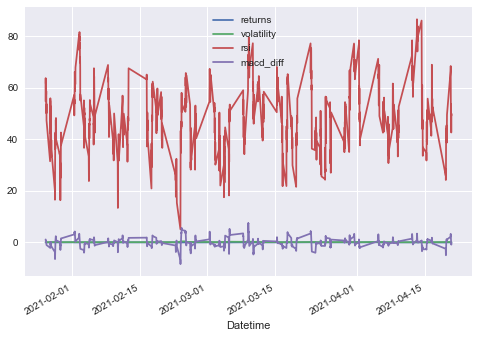

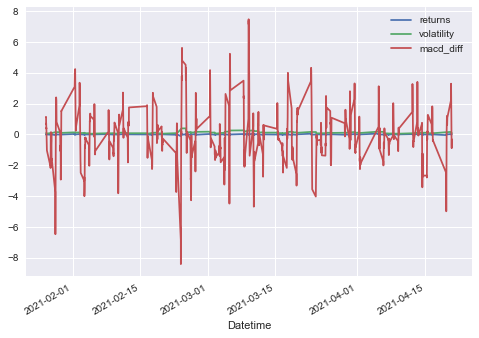

In [91]:
df_indicators=get_indicators(df).dropna()
df_indicators.plot()

df_indicators_only=df_indicators.drop(columns=['Volume','High','Open','Close','Low','Adj Close'])
df_indicators_only.plot()

df_indicators_important=df_indicators_only.drop(columns='rsi')
df_indicators_important.plot()

Feature:  rsi Score: 0.9090344
Feature:  macd_diff Score: -4.5196989


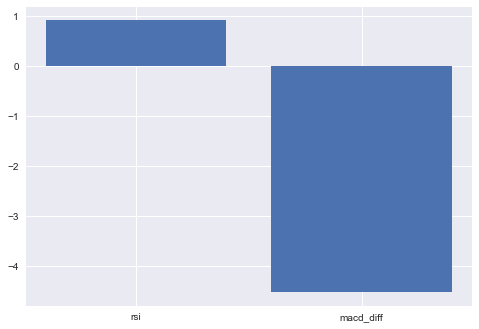

<AxesSubplot:>

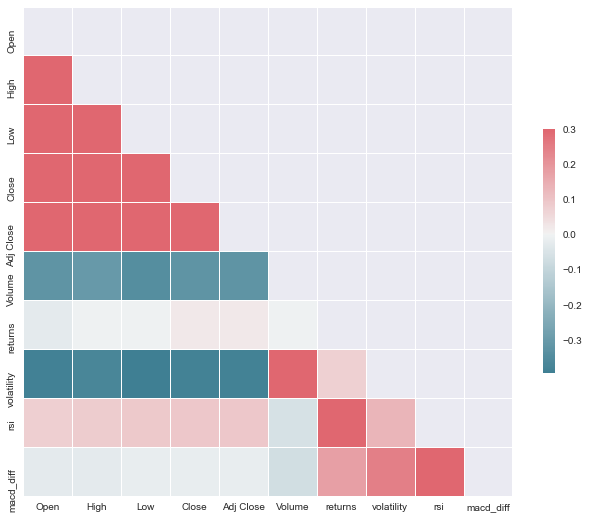

In [92]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# define dataset

X, y = make_regression(n_samples=1547, n_features=6)
# define the model
model = LinearRegression()
# fit the model
X = df_indicators.drop(columns=['Open','High','Close','Adj Close','Low','returns','volatility','Volume'])
y = df_indicators['Close'].values
model.fit(X, y)
#Mapping column names for feature importance graph
map_colums ={}
col =df_indicators.drop(['Open','High','Close','Adj Close','Low','returns','volatility','Volume'],axis=1).columns
for i in range(len(col)):
 map_colums[i] = col[i]
map_colums
# get importancea
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: ',map_colums[i],'Score: %.7f' % v)
# plot feature importance
plt.bar([map_colums[x] for x in range(len(importance))], importance)
plt.show()

data=df.dropna()
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [93]:
df = data.copy()
print(df.isna().sum())
df=df.drop(columns='Adj Close')
df=df[['Open', 'High', 'Low', 'Volume', 'returns','volatility', 'rsi', 'macd_diff','Close']]

df.Close.tail()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
returns       0
volatility    0
rsi           0
macd_diff     0
dtype: int64


Datetime
2021-04-20 13:00:00-04:00    713.159973
2021-04-20 13:15:00-04:00    714.200012
2021-04-20 13:30:00-04:00    716.929993
2021-04-20 13:45:00-04:00    718.049988
2021-04-20 13:51:53-04:00    717.544983
Name: Close, dtype: float64

In [106]:
# Define the features set 'X', and the target 'y' set.
X = df.iloc[:, 0:8].values
y = df.iloc[:, 8:9].values
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM RNN model.
model = Sequential()

number_units = 32
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
model.summary()
model.fit(X_train, y_train, epochs=5, shuffle=False, batch_size=3, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 32)             4352      
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 32)             8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 32)             8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)               

In [107]:
model.evaluate(X_test, y_test)
# Make some predictions
predicted = model.predict(X_test)

15/15 [==============================] - 2s 6ms/step - loss: 0.0150


In [109]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

<AxesSubplot:xlabel='Datetime'>

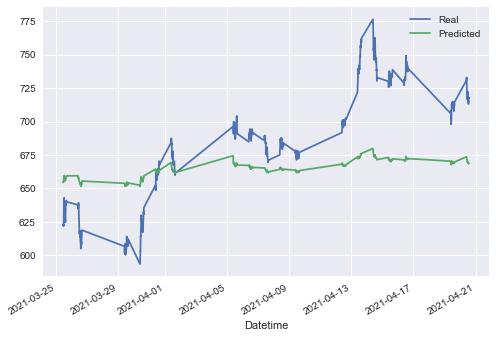

In [110]:
predicted_prices.shape
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()
stocks.plot()

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [97]:
# Scale the data for the features set X_tain and X_test
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# Create a neural network with 1 hidden layer
nn = Sequential()

nn.add(Dense(units=8, input_dim=8, activation="relu"))
nn.add(Dense(units=2, activation="linear"))

NameError: name 'Sequential' is not defined

In [ ]:
# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_1 = nn.fit(X_train_scaled, y_train, epochs=800, verbose=0)

In [ ]:
# Plot the train function
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(model_1.history["loss"])
plt.title("loss_function - training")
plt.legend(["loss"])
plt.show()

In [ ]:
nn_json = nn.to_json()
file_path = Path("../Resources/model.json")
with open(file_path, "w") as json_file:
    json_file.write(nn_json)

# Save weights
file_path = "../Resources/model.h5"
nn.save_weights(file_path)

In [ ]:
# Load the model to predict values
from tensorflow.keras.models import model_from_json

# Load json and create model
file_path = Path("../Resources/model.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# Load weights into new model
file_path = "../Resources/model.h5"
loaded_model.load_weights(file_path)

In [112]:
# Predict values using the testing data
from sklearn.metrics import mean_squared_error



In [113]:
# Evaluate the model with the MSE metric
print(mean_squared_error(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [73]:
df

,Open,High,Low,Volume,returns,volatility,rsi,macd_diff,Close
Datetime,,,,,,,,,
2021-01-26 11:15:00-05:00,886.623596,889.869995,886.088989,814392,-0.000036,0.087966,61.600593,1.131698,886.219971
2021-01-26 11:30:00-05:00,886.300171,890.989502,886.286011,758376,0.002331,0.085519,63.653608,1.142518,888.285400
2021-01-26 11:45:00-05:00,888.469910,888.469910,881.830017,801292,-0.006716,0.087045,54.577592,0.684747,882.320007
2021-01-26 12:00:00-05:00,882.320007,887.880005,882.000000,564307,0.006109,0.085981,60.111764,0.680384,887.710022
2021-01-26 12:15:00-05:00,887.719971,889.398987,886.299988,499555,0.001581,0.071216,61.429163,0.704448,889.113098
...,...,...,...,...,...,...,...,...,...
2021-04-20 11:45:00-04:00,716.599976,720.429993,716.049988,1381437,0.002274,0.090749,48.543635,-0.124985,718.280029
2021-04-20 12:00:00-04:00,718.310303,723.409424,716.929993,1155290,0.005699,0.091531,53.631595,0.009888,722.373596
2021-04-20 12:15:00-04:00,722.390015,722.859985,718.530029,738745,-0.004753,0.092595,49.234129,-0.132589,718.940002


In [75]:
X[0]

array([ 8.86623596e+02,  8.89869995e+02,  8.86088989e+02,  8.14392000e+05,
       -3.58118139e-05,  8.79661021e-02,  6.16005932e+01,  1.13169806e+00])

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(data) - window):
        features = data.iloc[i : (i + window), :-1]
        target = data.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)
    # Define the window size
window_size = 32

# Set the index of the feature and target columns
feature_column = 3
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

In [ ]:
data

### Getting a visual of the data

In [ ]:
# df = df['2019']
# temp = df.Close.pct_change()
# temp1 = temp.pct_change()
# comb = pd.concat([temp,temp1], axis = 'columns').rolling(200).mean()
# comb.columns = ['A','B']
# comb.plot(secondary_y = 'B')

In [ ]:
# # Another strategy.

# # If min is the same for x number of minutes, buy
# # If max is the same for x number of minues, sell.
# # df.Close.plot(figsize = (30,12))
# # low = df.Close.rolling(500).min()
# high = df.Close.rolling(100).max()
# volume = df.Volume.rolling(window = 100).mean()
# df[['Close','Volume']].rolling(window = 200).mean().plot(secondary_y = 'Volume')
# # short_low = low.rolling(window = 50).mean()
# # long_low = low.rolling(window = 100).mean()

# # # The lowest high of the last 50 time periods
# # lowest_high = high.rolling(window = 70).min()
# # # The highest high of the last 200 time periods.
# # highest_high = high.rolling(window = 200).max()

# # df[['Close','Volume']].plot(figsize = (20,15),
# #                                       secondary_y = 'Volume')
# # sma = df.Close.rolling(window = 75).mean() * 1.12
# # # sma1 = df.Close.rolling(window = 100).mean() * 0.95
# # low = df.Close.rolling(window = 200).min().rolling(window = 75).mean()
# # floor = df.Close.rolling(window = 150).min()

# # floor.plot()
# # low.plot()
# # sma.plot()
# # lowest_high.plot()
# # highest_hi
# # # When the 
# # lowest_high.plot()
# # highest_high.plot()







In [ ]:
# df.Close.plot(figsize = (30,15))

# upper = df.Close.rolling(50).mean() + df.Close.rolling(50).std() * 1
# lower = df.Close.rolling(50).mean() - df.Close.rolling(50).std() * 1
# middle = df.Close.rolling(50).mean()

# upper.plot()
# lower.plot()
# middle.plot()

In [ ]:
# start_day = str(df.index[0]).split(' ')[0]
# end_day = str(df.index[-1]).split(' ')[0]

# twenty_day_max = df.High.rolling(window = 5).max()
# # twenty_day_low = df.Low.rolling(window = 5).min()

# rolling_short = df.Close.rolling(window = 40).mean()
# rolling_long = df.Close.rolling(window = 160).mean()

# df.Close.plot(figsize = (30,10),
#              title = f'{ticker} Closing Prices from {start_day} to {end_day}', grid = True)
# # twenty_day_max.plot()
# # twenty_day_low.plot()
# rolling_short.plot()
# rolling_long.plot()

# NOTE: It would be cool for this graph to display VOLUME and their averages under this.

# Potential Buy Strategy.
### Buy when 10 up crosses 20 only if you don't have any stock already.
### Sell if actual stock price is less than X% of the X-day max price.

In [ ]:


df.Close.plot(figsize = (30,10))


In [ ]:
# Optional
#df = df.Close

### Changing the absolute values to percents

In [ ]:
close_price_change = df.pct_change()

# 2. Trading Strategies

* Create a strategy that does well in BULL markets.
* Create a strategy that does well in BEAR markets.
* Create charts for both visually showing entry end exit points.
* Figure out how much would be made with a buy and hold strategy
* Create a cumulative returns graph to display the difference

# This strategy does very well in markets that are more on the bear size.
### Meaning that the market doesn't have to be full bear, just at least mostly bear.

In [ ]:
df1 = df.copy()
# Set the short window and long windows
#40,80 works best so far.
short_sma = 40
long_sma = 80

In [ ]:
df1[f"{short_sma} SMA"] = df1.Close.rolling(short_sma).mean() 
df1[f"{long_sma} SMA"] = df1.Close.rolling(long_sma).mean() 

In [ ]:
df1.head(5)

The 1,-1 means that your are long when short sma > long sma, and short otherwise.

In [ ]:
df1['Position'] = np.where(df1[f'{short_sma} SMA'] > df1[f'{long_sma} SMA'],1,-1)

In [ ]:
df1['log_returns'] = np.log(df1['Close'] / df1['Close'].shift(1))

In [ ]:
df1['strategy_returns'] = df1.Position.shift(1) * df1['log_returns']

In [ ]:
df1.dropna(inplace = True)
df1.head()

#### Cumulative Sum

In [ ]:
df1[['log_returns','strategy_returns']].sum()
# Note that these give you the same ending value
# df1['log_returns'].cumsum()[-1]

In [ ]:
df1[['log_returns','strategy_returns']].sum().apply(np.exp) * 1000

In [ ]:
df1['BH CR'] = df1['log_returns'].cumsum().apply(np.exp) * 1000
df1['S CR'] = df1['strategy_returns'].cumsum().apply(np.exp) * 1000

df1[['BH CR','S CR']].plot()

In [ ]:
# exit = df[df['Position'] == -1.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize total portoflio value for the investment
# total_portfolio_value = df[['Portfolio Total']].hvplot(
#     line_color='lightgray',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Overlay plots
# portfolio_entry_exit_plot = total_portfolio_value * entry * exit
# portfolio_entry_exit_plot.opts(xaxis=None)

In [ ]:
# df1['Signal'].value_counts()

In [ ]:
# df['Signal'].value_counts()

In [ ]:
# df['Entry/Exit'].value_counts()

# 3. Combining Trading Strategies

* Combine the strategies
* Figure out a trigger that allows the model to switch between strategies.
* Backtest the combined strategy
* Compare the cumulative returns of the buy and hold vs this strategy.

# 4. Predictive Model (Doesn't Work)
* Create a model that can predict future prices.
* Check to see if the model is over or underfit.
* Apply the combined strategy with the predicted values
* Backtest /forward test.
* Compare using a cumulative returns graph.

### Seeing which columns actually correlate.
Low correlation does not help the model.
Does high correlation actually do better?    

In [ ]:
# sns.set_style("darkgrid")
correlation = close_price_change.corr()

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Correlation between OHLCV')
heat_map = sns.heatmap(data = correlation,
#                        x = correlation.Close,
                       annot=True,
                      ax = ax)
heat_map

## This is to help us easily see which columns have low correlation to Close
### So if you were to decide to put other data in the main dataframe, this would hopefully filter that out if it wasn't useful

In [ ]:
print('Correlations')
correlations = pd.DataFrame([correlation[x] for x in correlation][0])
print(correlations)

# Automatically keeping the high correlations
keepers = correlations[correlations.Close> 0.6]
keeper_columns = list(keepers.index)
print('\n\nHigh Correlations')
keeper_columns

### I would say to only keep High and Low

In [ ]:
# df1 = df1.loc[:,keeper_columns]
# df1 = df1[['Low','High','Close']]
# df1

### Separating the data into X and y

# THE PROBLEM WITH THIS MODEL
## It doesn't predict into the actual future. It only predicts things that have already happened. 
Pretty lame. I will try to get it to predict future values.

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
df1.keys()

In [ ]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0 # Close
target_column = 0
X, y = window_data(df1, window_size, feature_column, target_column)

In [ ]:
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [ ]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=2, shuffle=False, batch_size=1, verbose=1)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
predicted = model.predict(X_test)


In [ ]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.tail()

In [ ]:
stocks.plot(title = "Aint worth shit. But damn. Ain't it pretty", figsize = (30, 10), secondary_y = 'Predicted')

In [ ]:
df.reset_index(inplace = True)

In [ ]:
df = df[['Date','Close']]
df.columns = ['Date','Close']
df.tail()

In [ ]:

close_data = df.Close.values.reshape((-1))
look_back = 10
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       
        out = model.predict(x)
        output=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, output)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    


num_prediction = 2
forecast = predict(num_prediction, model)


In [ ]:
prediction = pd.DataFrame({"Prediction":forecast} )
prediction

In [ ]:
prediction.set_index('Date', inplace = True)

In [ ]:
df.set_index('Date', inplace = True)

In [ ]:
df

In [ ]:
  def get_indicators(data):
    #calculate all indicators
    open =data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    data['rsi']=ta.momentum.rsi(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data['vortex']=ta.trend.vortex_indicator_neg(high, low, close)
    data['cmd']=ta.volume.chaikin_money_flow(high, low, close, volume)
   
    
   
    
    data['eom']=ta.volume.ease_of_movement(high, low, close, volume)
   
    data['nvi']=ta.volume.negative_volume_index(close, volume)
    
    data['boll_high']=ta.volatility.bollinger_hband_indicator(close)
    data['atr']=ta.volatility.average_true_range(high, low, close)
     
    data['aroon']=ta.trend.aroon_down(close)
    data['dpo']=ta.trend.dpo(close)

    return data

In [ ]:
def best_indicators(data):
    #calculate all indicators
    open =data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    data['rsi']=ta.momentum.rsi(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data['vortex']=ta.trend.vortex_indicator_neg(high, low, close)
    data['cmd']=ta.volume.chaikin_money_flow(high, low, close, volume)
    return data

In [ ]:
df=best_indicators(df)

In [ ]:
df=get_indicators(df)
data=df.dropna().reset_index()
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# define dataset
X, y = make_regression(n_samples=2373, n_features=17)
# define the model
model = LinearRegression()
# fit the model
X = data.drop(['Close','Datetime',],axis=1).values
y = data['Close'].values
model.fit(X, y)
#Mapping column names for feature importance graph
map_colums ={}
col =data.drop(['Close','Datetime'],axis=1).columns
for i in range(len(col)):
 map_colums[i] = col[i]
map_colums
# get importancea
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: ',map_colums[i],'Score: %.7f' % v)
# plot feature importance
plt.bar([map_colums[x] for x in range(len(importance))], importance)
plt.show()

# 5. Conclusions
* How did our model do compared to a buy and hold strategy?
    * Buy how much did or didn't it suck.
    * Cumulative returns
    * Risk
    * Number of trades
    * Number of gains / (Number of gains + Number of losses)
    * ## Anything else you guys think would help in the comparison.

# Notes to eventually add to the conclusion.

We learned that using a neural network model to predict stocks is pretty naive. That doesn't seem to be their strong point. They can predict "future" prices so long as they have "future" prices to learn from. The closest I found of someone using them to actually predict future prices was a couple of people who could predict prices one day out. Now if you kept doing this, this model might be of some use. However, I couldn't get that figured out.

In [ ]:
len(df.columns)